# Use Toronto neihgbourhood data to generate meaningful location data for bikeshare locations

In [34]:
import pandas as pd
import geopandas as gpd
#import geoplot as gplt
#import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import requests
import json
from shapely.geometry import shape

# Get the dataset metadata by passing package_id to the package_search endpoint
# For example, to retrieve the metadata for this dataset:

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = { "id": "4def3f65-2a65-4a4f-83c4-b2a4aed72d46"}
package = requests.get(url, params = params).json()
url = package["result"]["resources"][0]['url']

# Get the data by passing the resource_id to the datastore_search endpoint
# See https://docs.ckan.org/en/latest/maintaining/datastore.html for detailed parameters options
# For example, to retrieve the data content for the first resource in the datastore:

for idx, resource in enumerate(package["result"]["resources"]):
    #print(resource)
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = { "id": resource["id"] }
        print(type(requests.get(url, params = p)))
        data = requests.get(url, params = p).json()
        #print(data)
        df = pd.DataFrame(data["result"]["records"])
        break
        
#define function to parse the geometry column
#This is not extremely efficient but I can't figure out how another work around 
#besides downloading the JSON file and useing gpd.read_file
def parse_geom(geom_str):
    return shape(json.loads(geom_str))
    try:
        return shape(json.loads(geom_str))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None
#assign the function to the correct column
df["geometry"] = df["geometry"].apply(parse_geom)

#turn this into a geopandas dataframe
gdf = gpd.GeoDataFrame(df, geometry="geometry")
print(gdf.head())

<class 'requests.models.Response'>
     _id  AREA_ID  AREA_ATTR_ID PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0  11481  2480141      26005521           None             096            096   
1  11482  2480140      26005520           None             095            095   
2  11483  2480139      26005519           None             109            109   
3  11484  2480064      26005444           None             064            064   
4  11485  2480063      26005443           None             103            103   

                   AREA_NAME                  AREA_DESC     X     Y LONGITUDE  \
0             Casa Loma (96)             Casa Loma (96)  None  None      None   
1                 Annex (95)                 Annex (95)  None  None      None   
2   Caledonia-Fairbank (109)   Caledonia-Fairbank (109)  None  None      None   
3     Woodbine Corridor (64)     Woodbine Corridor (64)  None  None      None   
4  Lawrence Park South (103)  Lawrence Park South (103)  None  None      

<AxesSubplot:>

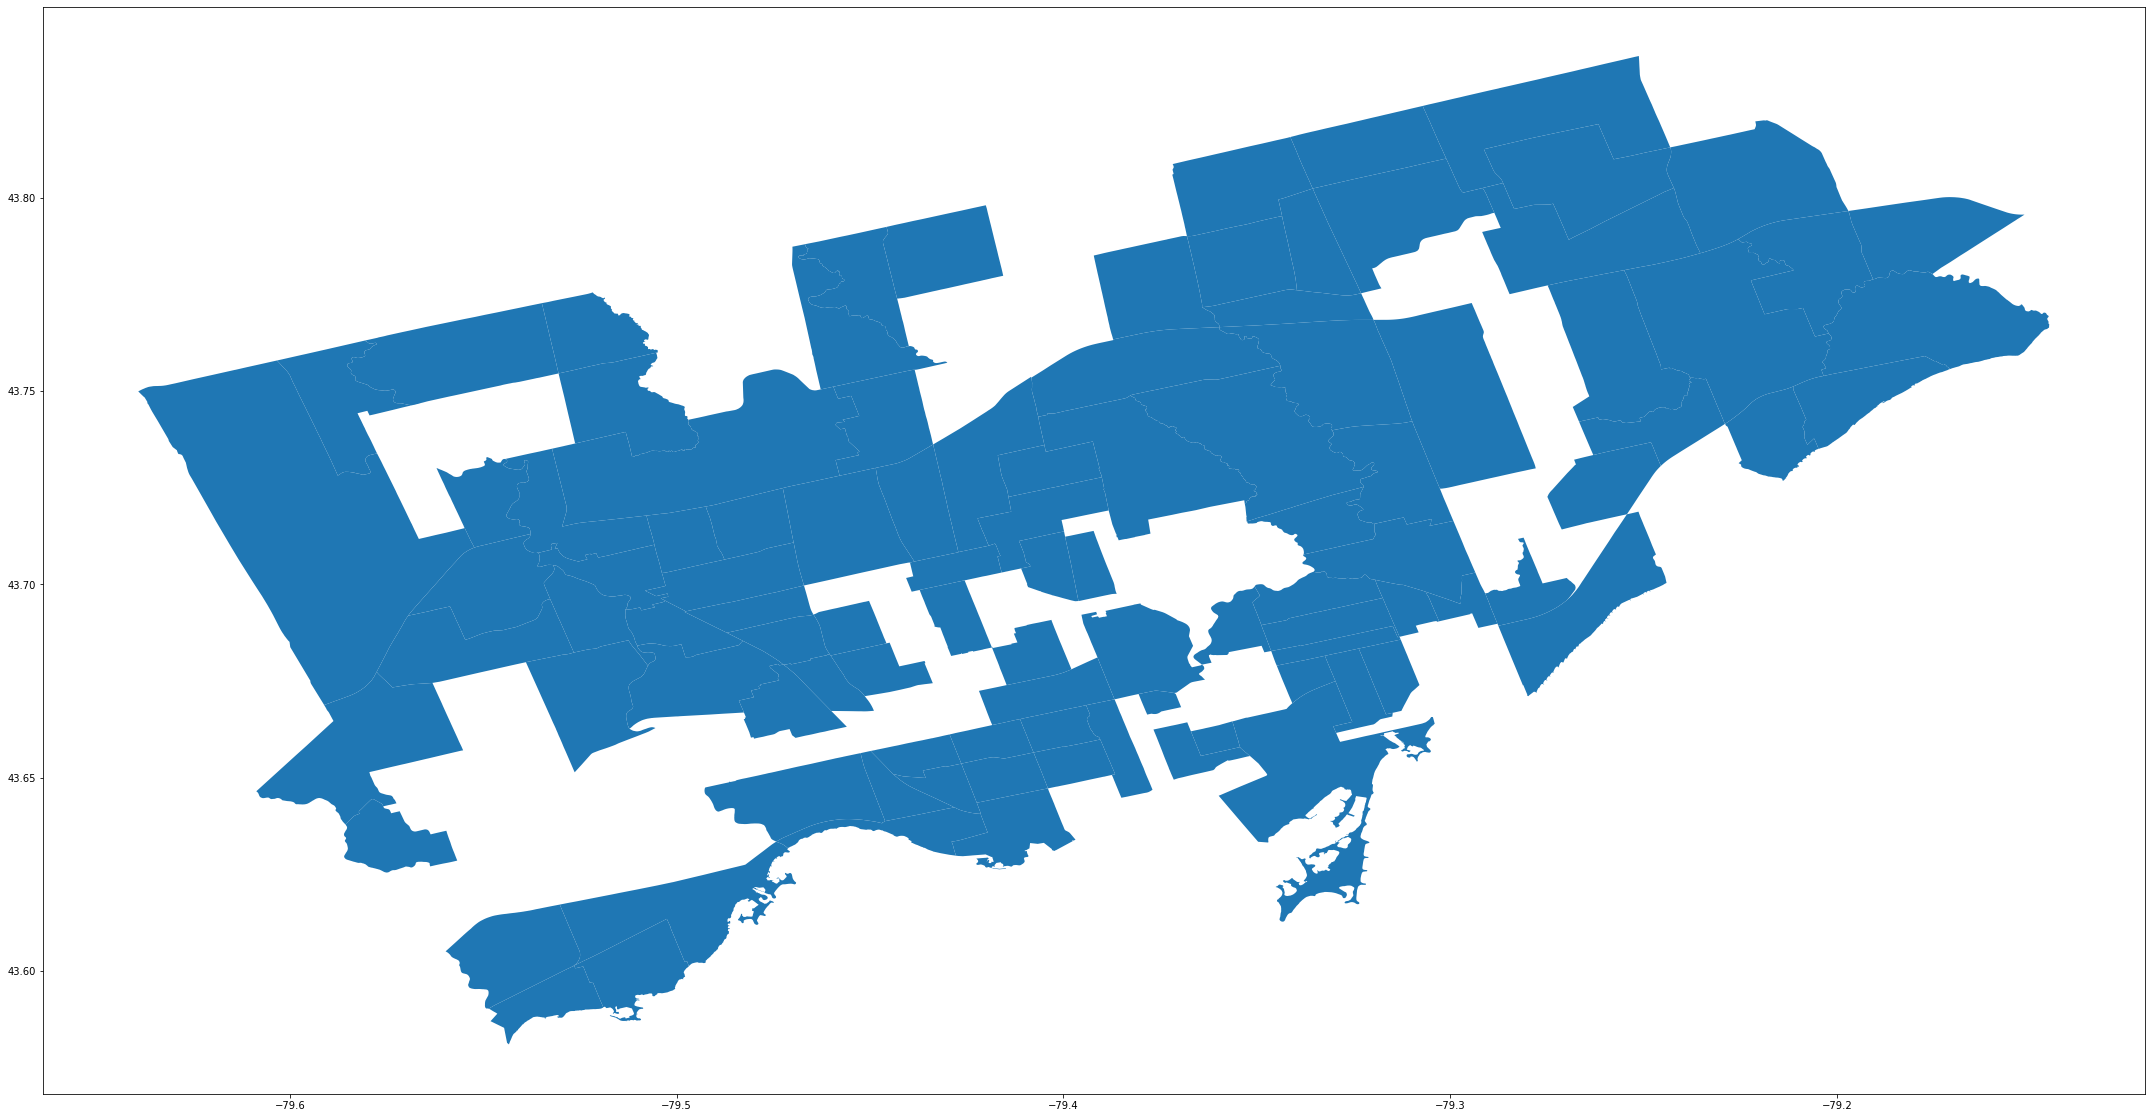

In [35]:
gdf.plot(figsize=(40,20))